## Detecting Heteregeneous Effects In RCTs Using Multilevel Models

In [1]:
%config InlineBackend.figure_format = 'retina'

import pymc3 as pm
import theano.tensor as T
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from opossum import UserInterface

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
az.style.use("arviz-darkgrid")


Generate some sample Randomized Controlled Trial (RCT) data exhibiting heterogenous treatment effects. For details see: https://humboldt-wi.github.io/blog/research/applied_predictive_modeling_19/data_generating_process_blogpost/

In [2]:
# number of observations N and number of covariates k
N = 100000
k = 50
# initilizing class
u = UserInterface(N, k, seed=1922, categorical_covariates = k)
# assign treatment and generate treatment effect 
# that is positive for 20%, negative for 20%, and neutral for 60%
u.generate_treatment(random_assignment = True, 
                     assignment_prob = 0.5, 
                     treatment_option_weights = [0, 0, 0.2, 0.2, 0.6, 0], 
                     intensity = 5)


# generate output variable y and return all 4 variables
y, X, assignment, treatment = u.output_data(binary=True, x_y_relation = 'linear_interaction')

subgroup = [item[0] for item in X]

In [3]:
# construct a dataframe from numpy arrays

df = pd.DataFrame()
df['y'] = pd.Series(y) 
df['subgroup'] = pd.Series(subgroup, dtype='str')
df['assignment'] = pd.Series(assignment, dtype='int32')
df['treatment'] = pd.Series(treatment)

# filter out groups with fewer than 500 observations
df = df.groupby('subgroup').filter(lambda x: len(x) > 500) 

In [4]:
df.sample(10)

y subgroup  assignment  treatment
31789  0     25.0           1   0.027464
28366  1     25.0           1   0.036482
32772  0     28.0           1   0.000000
85141  0     31.0           0  -0.000000
3019   1     30.0           1   0.000000
79667  1     31.0           1   0.000000
28297  1     16.0           0   0.000000
82557  1     29.0           0   0.000000
56246  0     25.0           0   0.000000
61331  1     31.0           0   0.000000

In [5]:
df.dtypes

y               int64
subgroup       object
assignment      int32
treatment     float64
dtype: object

In [6]:
# Encode subgroups; print number of subgroups

le = preprocessing.LabelEncoder()
subgroup_idx = le.fit_transform(df['subgroup'].astype(str))
n_subgroups = len(set(subgroup_idx))
print(n_subgroups)

29


In [19]:
# get the reverse mapping for later lookup

d = dict(zip(le.classes_, le.transform(le.classes_)))
ivd = {v: k for k, v in d.items()}


- "y" is our binary outcome variable indicating, for example, whether or not a user takes an intended action 
- "subgroup" is a categorical variable representing the subgroup of interest (e.g., the user's country of origin)
- "assignment" indicates whether or not the user was assigned to treatment
- "treatment" indicates the true effect of the treatment 

In [7]:
# show the number of observations in each subgroup, broken down by assignment 

df.groupby(['subgroup', 'assignment']).size().unstack(fill_value=0)

assignment     0     1
subgroup              
13.0         280   289
14.0         430   426
15.0         617   587
16.0         777   808
17.0         946   977
18.0        1157  1187
19.0        1435  1558
20.0        1736  1782
21.0        1999  2027
22.0        2281  2269
23.0        2551  2484
24.0        2779  2769
25.0        2929  2894
26.0        3016  3027
27.0        3090  3056
28.0        3041  3006
29.0        2947  2997
30.0        2768  2769
31.0        2597  2534
32.0        2381  2296
33.0        2054  1911
34.0        1713  1716
35.0        1453  1492
36.0        1176  1170
37.0         936   940
38.0         736   735
39.0         559   554
40.0         378   349
41.0         262   257

In [8]:
# show the overall mean outcome, by assignment 

df[['y', 'assignment']].groupby(['assignment']).mean()

y
assignment         
0           0.57890
1           0.57363

In [9]:
# show the mean outcome for each subgroup, broken down by assignment 

df[['y', 'subgroup', 'assignment']].groupby(['subgroup', 'assignment']).mean()

y
subgroup assignment          
13.0     0           0.646429
         1           0.577855
14.0     0           0.574419
         1           0.572770
15.0     0           0.607780
         1           0.592845
16.0     0           0.586873
         1           0.589109
17.0     0           0.601480
         1           0.598772
18.0     0           0.574762
         1           0.610783
19.0     0           0.588850
         1           0.584082
20.0     0           0.589286
         1           0.594276
21.0     0           0.583292
         1           0.576221
22.0     0           0.573433
         1           0.565007
23.0     0           0.572325
         1           0.572464
24.0     0           0.585103
         1           0.579270
25.0     0           0.576306
         1           0.583276
26.0     0           0.572613
         1           0.553353
27.0     0           0.584790
         1           0.571662
28.0     0           0.576784
         1           0.546574
29.0     0           0.585341
         1           0.574241
30.0     0           0.567919
         1           0.582160
31.0     0           0.580670
         1           0.576953
32.0     0           0.581268
         1           0.560105
33.0     0           0.574976
         1           0.577708
34.0     0           0.583771
         1           0.564685
35.0     0           0.571232
         1           0.567694
36.0     0           0.556122
         1           0.558120
37.0     0           0.557692
         1           0.577660
38.0     0           0.580163
         1           0.600000
39.0     0           0.572451
         1           0.546931
40.0     0           0.563492
         1           0.535817
41.0     0           0.561069
         1           0.622568

In [11]:
# define a multilevel model with varying slope and intercept

with pm.Model() as multilevel_model:
    
    # Hyperpriors for intercept
    mu_a = pm.StudentT('mu_a', nu=3, mu=0., sd=1.0)
    sigma_a = pm.HalfNormal('sigma_a', sd=1.0)
    
    # Hyperpriors for slope
    mu_b = pm.StudentT('mu_b', nu=3, mu=0., sd=1.0)
    sigma_b = pm.HalfNormal('sigma_b', sd=1.0)
    
    # Model the intercept
    # see: https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/
    a_offset = pm.Normal('a_offset', mu=0, sd=1, shape=n_subgroups)
    a = pm.Deterministic('a', mu_a + a_offset * sigma_a)
    
    # Model the slope
    b_offset = pm.Normal('b_offset', mu=0, sd=1, shape=n_subgroups)
    b = pm.Deterministic('b', mu_b + b_offset * sigma_b)
    
    a_inv = pm.Deterministic('a_inv', T.exp(a)/(1 + T.exp(a)))
    
    fin = pm.Deterministic('fin', T.exp(a + b)/(1 + T.exp(a + b)))
    
    # Calculate predictions given values for intercept and slope
    yhat = pm.invlogit(a[subgroup_idx] + b[subgroup_idx] * df.assignment.values)
    
    y = pm.Binomial('y', n=np.ones(df.shape[0]), p=yhat, observed=df.y.values)

In [14]:
with multilevel_model:
    mm_trace = pm.sample(5000, tune=5000, target_accept=0.99)

/Users/markgiangreco/.python-virtual-environments/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b_offset, a_offset, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 5_000 tune and 5_000 draw iterations (10_000 + 10_000 draws total) took 14275 seconds.


/Users/markgiangreco/.python-virtual-environments/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  """Entry point for launching an IPython kernel.
/Users/markgiangreco/.python-virtual-environments/pymc3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


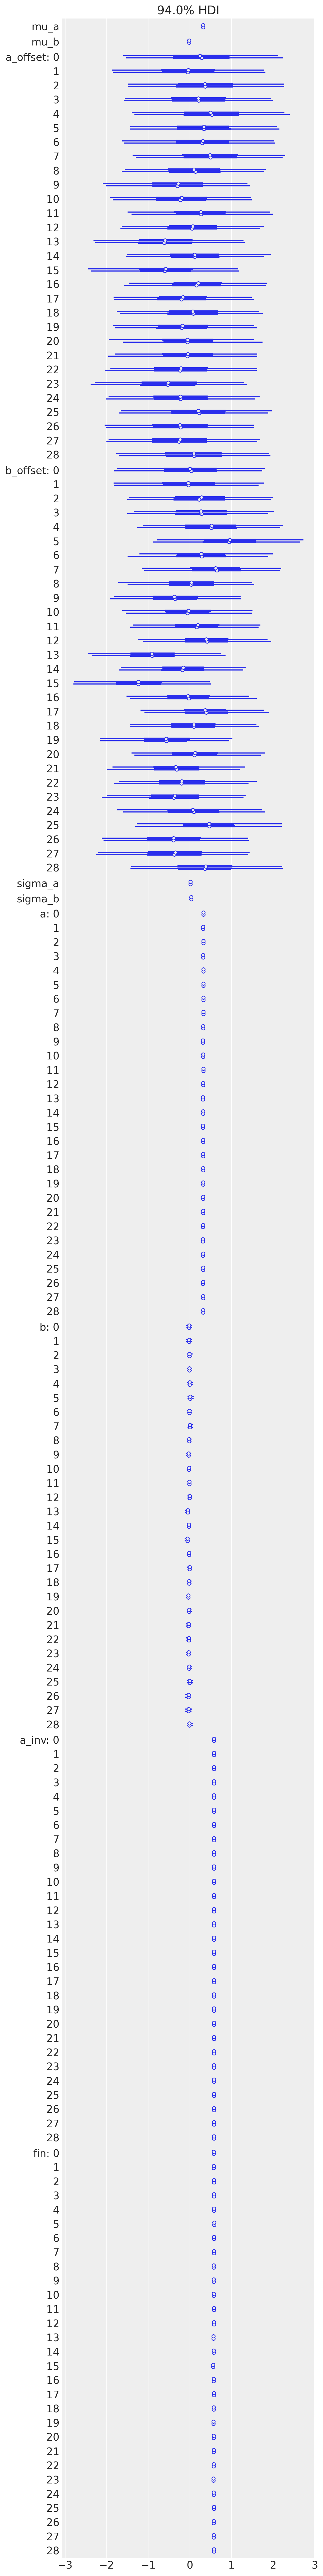

In [16]:
pm.forestplot(mm_trace);

/Users/markgiangreco/.python-virtual-environments/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
/Users/markgiangreco/.python-virtual-environments/pymc3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


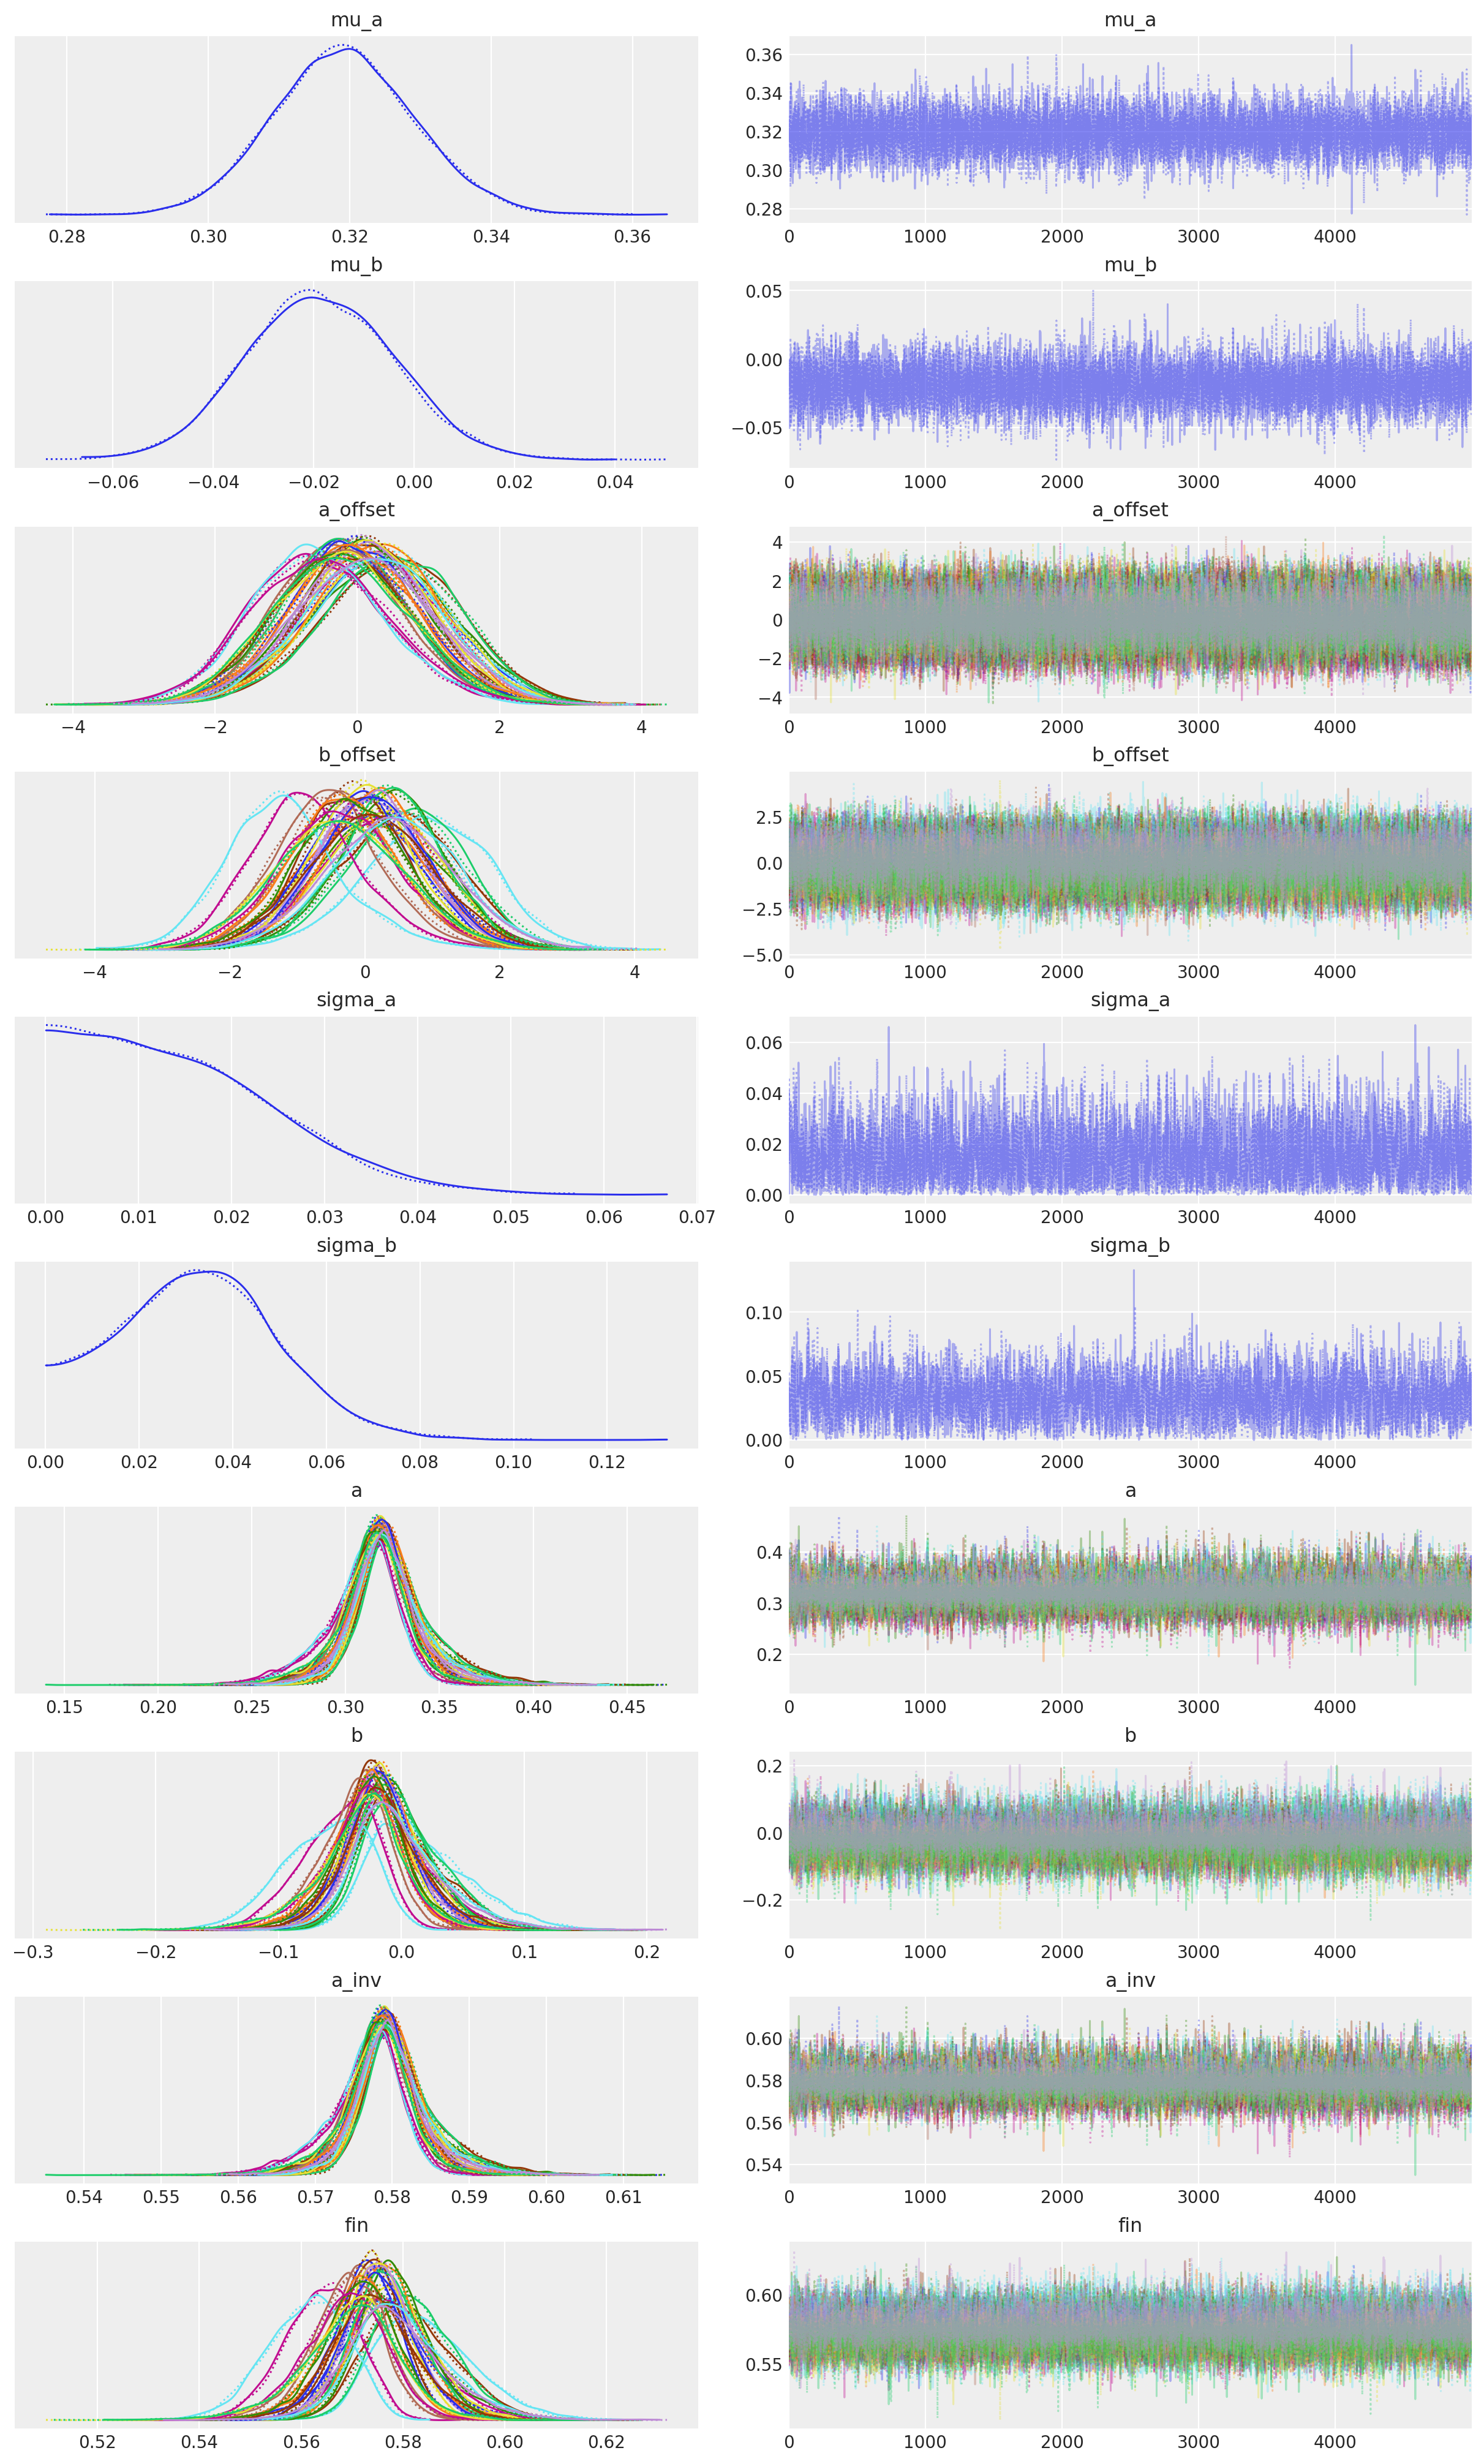

In [17]:
pm.traceplot(mm_trace);

In [20]:
# sample from posteriors to determine probability treatment better than control for each subgroup

for i in range(0, (n_subgroups-1)):
    print(ivd.get(i), np.mean(mm_trace.get_values('a_inv')[:, i] < mm_trace.get_values('fin')[:, i]))


13.0 0.2672
14.0 0.2488
15.0 0.342
16.0 0.3522
17.0 0.4448
18.0 0.6012
19.0 0.3487
20.0 0.4967
21.0 0.2475
22.0 0.1197
23.0 0.2131
24.0 0.2918
25.0 0.3954
26.0 0.0302
27.0 0.1582
28.0 0.0166
29.0 0.2051
30.0 0.3952
31.0 0.262
32.0 0.0737
33.0 0.277
34.0 0.1275
35.0 0.1702
36.0 0.1315
37.0 0.2894
38.0 0.4202
39.0 0.147
40.0 0.157


Open Questions:
- Can this model be reparameterized to run much faster?
- Can this model be generalized to the case where multiple sets of subgroups exist (e.g., device type, site visit history, etc.)? Or would we need to fit a new model for each subgroup?
- Can we specify a similar model for instances where the target variable is continuous rather than binary?